In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from scplainer import model
from anndata import AnnData
from tqdm import tqdm
tqdm.pandas()

In [128]:
from rpy2.robjects import pandas2ri

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()

from rpy2.robjects.packages import importr

nipals = importr('nipals')

Plot the experimental design like so:

Heatmap with:
x-axis Plate col, y-axis Plate row, color = subject or location or number of ids ...

In [2]:
data = pd.read_csv('/home/samva/EUBIC_2025/report.tsv', sep='\t')

classes = [
    'lvepi',
    'lvendo',
    'rv',
    'lvmid',
    'sytox'
]
def extract_cell_type(run):
    
    elements = run.split('_')
    for element in elements:
        if element.lower() in classes:
            return element.lower()

def extract_well(run):
    if 'sytox' in run:
        return run.split('_')[4]
    el = run.split('_')[3]
    if el.lower() in classes:
        return run.split('_')[4]
    return run.split('_')[3]

def extract_position(run):
    if 'sytox' in run:
        return run.split('_')[5]
    el = run.split('_')[3]
    if el.lower() in classes:
        return run.split('_')[5]
    return run.split('_')[4]

data['cell_type'] = data['Run'].apply(extract_cell_type)
data['well'] = data['Run'].apply(extract_well)
data['position'] = data['Run'].apply(extract_position)
data['subject'] = data['Run'].apply(lambda x: x.split('_')[1])
data['acquisition_data'] = data['File.Name'].apply(lambda x: x.split('\\')[4].split('_')[0])

In [3]:
data.groupby('Run')['well'].value_counts().reset_index()['well'].value_counts()

well
A8     3
A15    3
A17    3
A18    3
A13    3
      ..
G13    1
F13    1
D13    1
C17    1
A9     1
Name: count, Length: 202, dtype: int64

In [4]:
data.groupby('Run')['cell_type'].value_counts().reset_index()['cell_type'].value_counts()

cell_type
lvepi     95
lvendo    69
rv        62
lvmid     52
sytox     21
Name: count, dtype: int64

In [ ]:
# TODO: Filter out protein groups

In [5]:
annotation_labels = ['cell_type', 'well', 'subject', 'acquisition_data', 'position']
annot_df = data[['File.Name']+ annotation_labels].drop_duplicates().set_index('File.Name').sort_index()
data_df = data.pivot_table(
    columns='Precursor.Id',
    index='File.Name',
    values='Precursor.Quantity'
).sort_index()

var = data[
    ['Precursor.Id', 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes']
].drop_duplicates().set_index('Precursor.Id')

In [6]:
anndata_object = AnnData(
    X=data_df,
    obs=annot_df,
    var=var
)

In [132]:
anndata_object

AnnData object with n_obs × n_vars = 299 × 12731
    obs: 'cell_type', 'well', 'subject', 'acquisition_data', 'position', 'NumberPeptides', 'MedianIntensity', 'MedianCV'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes'

In [7]:
anndata_object.obs

,cell_type,well,subject,acquisition_data,position
File.Name,,,,,
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A19_BA20_1_7451.d,lvepi,A19,Subject3,221019,BA20
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A20_BA21_1_7452.d,lvepi,A20,Subject3,221019,BA21
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A21_BA22_1_7453.d,lvepi,A21,Subject3,221019,BA22
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A22_BA23_1_7454.d,lvepi,A22,Subject3,221019,BA23
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A23_BA24_1_7455.d,lvepi,A23,Subject3,221019,BA24
...,...,...,...,...,...
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_F6_BF7_1_7832.d,rv,F6,Subject4,221024,BF7
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G5_BG6_1_7840.d,rv,G5,Subject4,221024,BG6
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G6_BG7_1_7841.d,rv,G6,Subject4,221024,BG7


In [8]:
anndata_object.obs['NumberPeptides'] = pd.DataFrame(anndata_object.X).notna().sum(axis=1).tolist()
anndata_object.obs['MedianIntensity'] = pd.DataFrame(np.log10(anndata_object.X)).median(axis=1).tolist()

In [9]:
anndata_object.obs

,cell_type,well,subject,acquisition_data,position,NumberPeptides,MedianIntensity
File.Name,,,,,,,
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A19_BA20_1_7451.d,lvepi,A19,Subject3,221019,BA20,4011,3.759918
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A20_BA21_1_7452.d,lvepi,A20,Subject3,221019,BA21,2576,3.851337
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A21_BA22_1_7453.d,lvepi,A21,Subject3,221019,BA22,6796,4.296521
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A22_BA23_1_7454.d,lvepi,A22,Subject3,221019,BA23,6523,4.246971
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A23_BA24_1_7455.d,lvepi,A23,Subject3,221019,BA24,2355,3.872481
...,...,...,...,...,...,...,...
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_F6_BF7_1_7832.d,rv,F6,Subject4,221024,BF7,849,3.914160
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G5_BG6_1_7840.d,rv,G5,Subject4,221024,BG6,1047,4.112055
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G6_BG7_1_7841.d,rv,G6,Subject4,221024,BG7,2108,4.042041


In [10]:
anndata_object.X_log10 = np.log10(anndata_object.X)

<Axes: xlabel='cell_type', ylabel='NumberPeptides'>

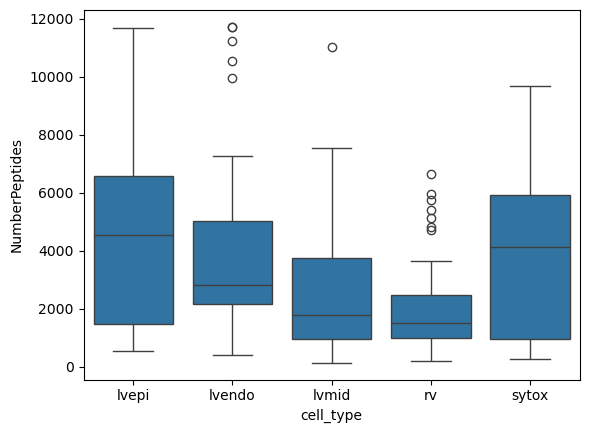

In [11]:
import seaborn as sns

sns.boxplot(
    anndata_object.obs,
    x='cell_type',
    y='NumberPeptides'
)

In [18]:
from scplainer.utils import medianCVperCell

In [15]:
len(anndata_object.X.T)

12731

In [97]:
matrix = pd.DataFrame(
    anndata_object.X_log10.T,
    columns=anndata_object.obs.index,
    index=anndata_object.var.index
)

In [98]:
from scplainer.utils import medianCVperCell

In [99]:
matrix.index.name = 'index'

In [100]:
anndata_object.var.reset_index().rename(columns={'index': 'Sequence'})

,Sequence,Protein.Group,Protein.Ids,Protein.Names,Genes
0,AAAEDVNVTFEDQQK2,Q9NQP4,Q9NQP4,PFD4_HUMAN,PFDN4
1,AAAEELLAR2,O15357,O15357,SHIP2_HUMAN,INPPL1
2,AAAEELPVGASAGPQPR2,Q8N3L3,Q8N3L3,TXLNB_HUMAN,TXLNB
3,AAAEVNQDYGLDPK2,P07954,P07954,FUMH_HUMAN,FH
4,AAAFEEQENETVVVK2,Q9Y490,Q9Y490,TLN1_HUMAN,TLN1
...,...,...,...,...,...
12726,YYTLNGSK2,P49748,P49748,ACADV_HUMAN,ACADVL
12727,YYTPTISR2,P49721,P49721,PSB2_HUMAN,PSMB2
12728,YYTVFDR2,P07339,P07339,CATD_HUMAN,CTSD
12729,YYVTIIDAPGHR2,P68104;Q5VTE0,P68104;Q5VTE0,EF1A1_HUMAN;EF1A3_HUMAN,EEF1A1;EEF1A1P5


In [101]:
medcv = medianCVperCell(
    assay=matrix,
    rowdata=anndata_object.var.reset_index().rename(columns={'index': 'Sequence'}),
    protein_col='Genes',
    nobs=3
)

100%|██████████| 299/299 [00:58<00:00,  5.13it/s]


In [102]:
anndata_object.obs = anndata_object.obs.reset_index().merge(
    pd.DataFrame(medcv).T.reset_index().rename(columns={0: "MedianCV", 'index': 'File.Name'})
).set_index('File.Name')

ValueError: Length of passed value for obs_names is 0, but this AnnData has shape: (299, 12731)

<Axes: xlabel='MedianCV', ylabel='Count'>

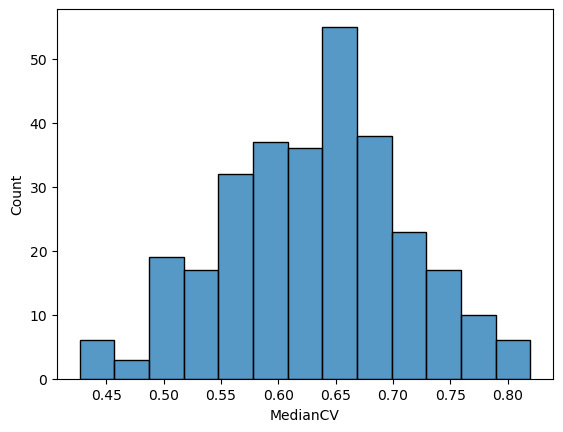

In [103]:
sns.histplot(anndata_object.obs['MedianCV'])

In [64]:
anndata_object.obs.columns

Index(['cell_type', 'well', 'subject', 'acquisition_data', 'position',
       'NumberPeptides', 'MedianIntensity', 'MedianCV'],
      dtype='object')

Text(0.5, 1.0, 'Acquisition')

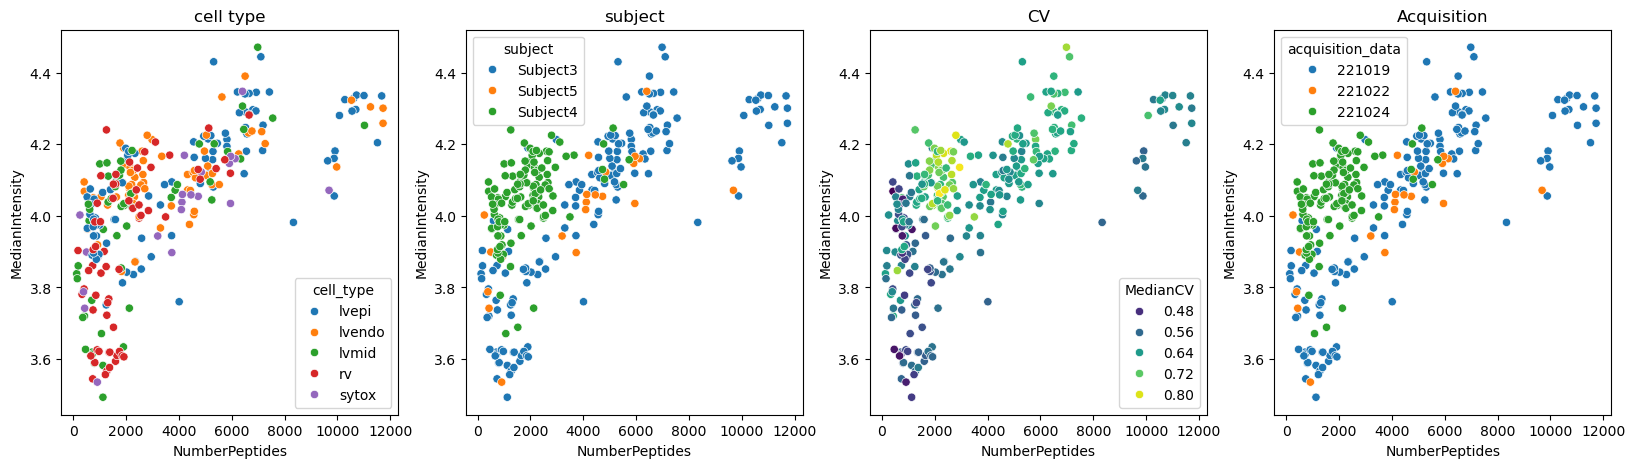

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))

sns.scatterplot(
    x=anndata_object.obs["NumberPeptides"],
    y=anndata_object.obs["MedianIntensity"],
    hue=anndata_object.obs["cell_type"],
    ax=ax[0]
)
sns.scatterplot(
    x=anndata_object.obs["NumberPeptides"],
    y=anndata_object.obs["MedianIntensity"],
    hue=anndata_object.obs["subject"],
    ax=ax[1]
)
sns.scatterplot(
    x=anndata_object.obs["NumberPeptides"],
    y=anndata_object.obs["MedianIntensity"],
    hue=anndata_object.obs["MedianCV"],
    palette="viridis",
    ax=ax[2]
)
sns.scatterplot(
    x=anndata_object.obs["NumberPeptides"],
    y=anndata_object.obs["MedianIntensity"],
    hue=anndata_object.obs["acquisition_data"],
    ax=ax[3]
)

ax[0].set_title('cell type')
ax[1].set_title('subject')
ax[2].set_title('CV')
ax[3].set_title('Acquisition')

In [67]:
numerical_variables = ['MedianIntensity']
categorical_variables = ['subject', 'cell_type']

In [105]:
from scplainer.model import scp_workflow

em, mm = scp_workflow(
    matrix,
    coldata=anndata_object.obs,
    numerical_variables=numerical_variables,
    categorical_variables=categorical_variables
)

100%|██████████| 12731/12731 [09:59<00:00, 21.22it/s]


In [106]:
em.collapse()

In [107]:
from scplainer.visualization import plot

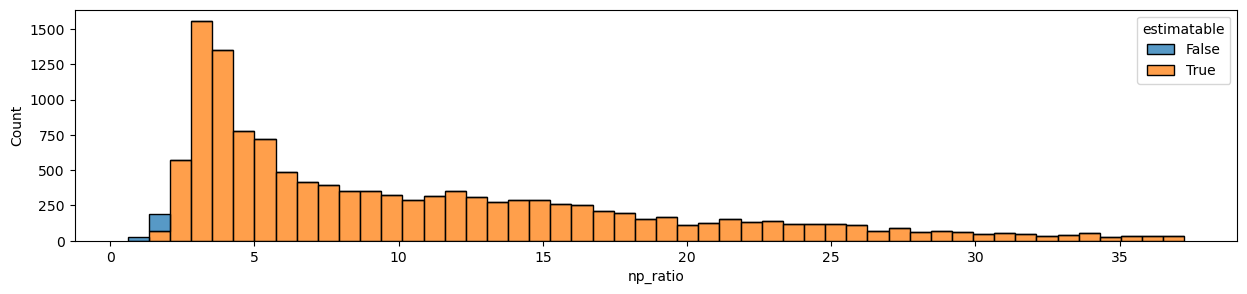

In [108]:
plot.plot_np_ratio(
    model_matrix=mm,
    kde=False,
)

In [109]:
keep_features = mm.matrix.index[(mm.matrix["np_ratio"] >= 3)]

# Only filtered when calling matrix property
mm.filter_features(features=keep_features)

# Stored in place
em.filter_features(features=keep_features)

effects = [
    "residual",
    "MedianIntensity",
    "subject",
    "cell_type"
]

In [110]:
from scplainer.analysis.variance import get_variance_matrices

variance_matrices = get_variance_matrices(em.matrices_collapsed, effects=effects, decomposed=False)

100%|██████████| 11732/11732 [00:03<00:00, 3652.93it/s]


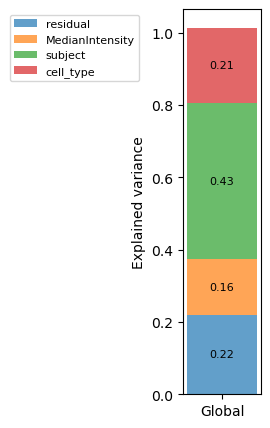

In [111]:
plot.create_stacked_barchart(
    feature_list=["Global"],
    data=variance_matrices.mean().to_dict(),
    n_charts=1
)

In [112]:
variance_matrices['residual']

AAAEELLAR2            0.095922
AAAEELPVGASAGPQPR2    0.094412
AAAEVNQDYGLDPK2       0.185389
AAAFEEQENETVVVK2      0.143803
AAALEQFK2             0.153232
                        ...   
YYTLNGSK2             0.240124
YYTPTISR2             0.087800
YYTVFDR2              0.153265
YYVTIIDAPGHR2         0.621003
YYVTIIDAPGHR3         0.430887
Name: residual, Length: 11732, dtype: float64

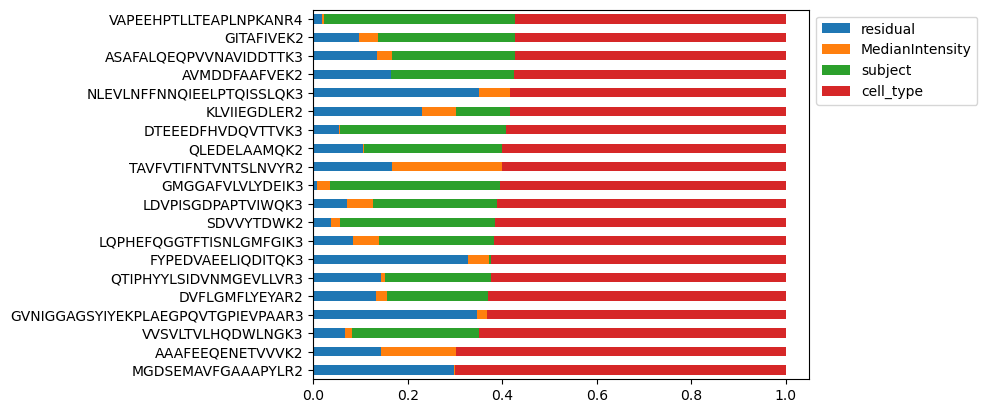

In [113]:
variance_matrices.sort_values("cell_type", ascending=False).iloc[0:20].plot(kind="barh", stacked=True)
plt.legend(bbox_to_anchor=(1, 1))

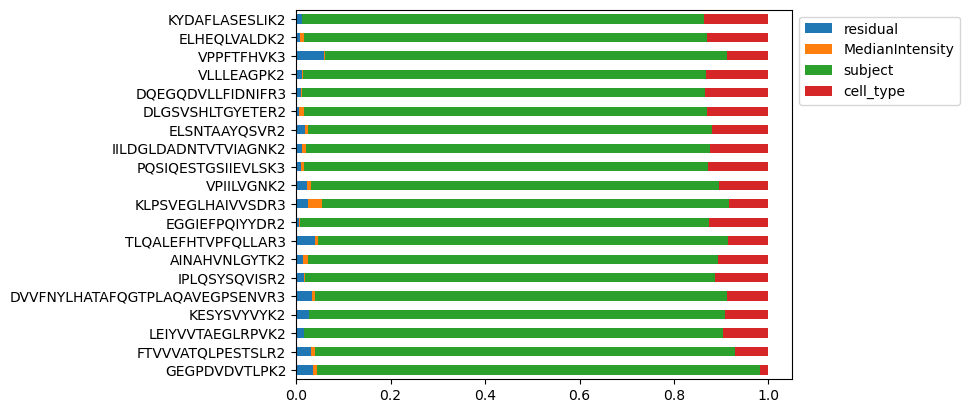

In [114]:
variance_matrices.sort_values("subject", ascending=False).iloc[0:20].plot(kind="barh", stacked=True)
plt.legend(bbox_to_anchor=(1, 1))

In [115]:
from scplainer.analysis.dea import differentialAnalaysis, scpDifferentialAnalysis
from scplainer.analysis.dea import get_contrast_matrix

Bug here

100%|██████████| 12731/12731 [00:00<00:00, 182975.31it/s]


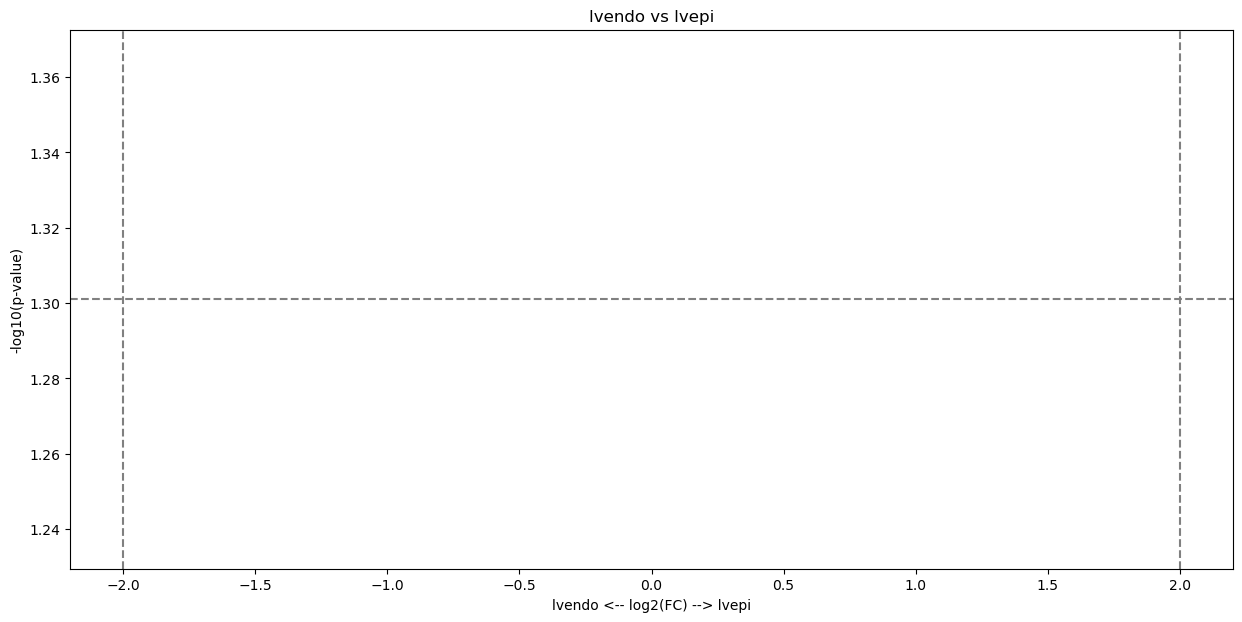

In [117]:
scpDifferentialAnalysis(
    model_matrix=mm,
    variable="cell_type",
    group_1="lvendo",
    group_2="lvepi"
)

n = max(mm.matrix.pval.notna().sum(), 1)

plot.volcano_plot(
    model_matrix=mm,
    group_1="lvendo",
    group_2="lvepi",
    highlight=True,
    pvalue_cutoff=.05/n,
    use_BH_pvalue=False
)

PCA

In [175]:
caRes['effect']['scores']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
AAAEELLAR2,-0.003569,-0.004062,0.000027,0.008603,0.001399,-0.004096,-0.006758,-0.001641,-0.005247,-0.004167,0.007205,-0.004580,0.008916,-0.000926,-0.002807,-0.000989,-0.000933,0.000693,-0.008150,-0.007257
AAAEELPVGASAGPQPR2,-0.007368,0.000649,-0.001545,0.001259,-0.015663,-0.001781,0.003524,-0.003952,0.005732,0.002687,0.001425,-0.001715,-0.003993,0.004632,-0.004249,0.010764,-0.002060,0.003811,-0.004466,-0.000739
AAAEVNQDYGLDPK2,-0.001531,0.008799,-0.018593,0.009059,-0.007208,-0.000026,-0.005055,-0.007815,0.012345,-0.014573,0.017897,-0.003553,-0.002303,-0.009014,-0.000378,0.014918,0.012441,0.000183,0.001966,-0.008065
AAAFEEQENETVVVK2,-0.013184,-0.000186,0.003573,0.000415,-0.018100,-0.003574,0.001687,-0.002715,-0.000769,0.012079,0.002453,-0.000601,-0.001649,-0.000779,-0.003714,0.004954,-0.002143,-0.001069,0.004602,-0.004807
AAALEQFK2,-0.002735,0.006340,-0.002630,0.003854,-0.006936,0.009974,-0.011980,0.005658,-0.004739,0.008042,0.015364,0.010243,0.010999,-0.001918,0.006012,-0.007025,-0.000890,0.000303,0.012005,-0.004498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYTLNGSK2,-0.002504,-0.000466,0.013967,-0.004353,-0.004033,0.012574,-0.011112,0.002928,-0.016153,-0.008076,0.007236,0.019755,-0.001009,0.007011,0.002314,-0.006025,0.021851,0.005995,-0.005314,0.007981
YYTPTISR2,-0.006396,-0.000110,0.003972,-0.003634,-0.010701,-0.002134,-0.000904,0.000421,-0.002609,0.002548,0.006633,0.003800,-0.007348,-0.003276,0.000917,0.000902,0.000367,-0.007562,-0.005475,0.002320
YYTVFDR2,0.000048,-0.007562,0.005591,0.005204,-0.001973,0.001054,0.014443,-0.002533,0.005256,-0.002879,0.003110,0.009049,0.006163,-0.004130,-0.011119,0.004333,0.006055,-0.008141,-0.007337,-0.015185
YYVTIIDAPGHR2,-0.005045,-0.011061,-0.004127,-0.001280,0.001339,0.000681,-0.012686,-0.021437,-0.006435,0.005425,0.009151,0.029514,0.010749,-0.003941,0.010661,0.039877,0.003716,0.018750,0.002978,0.005572


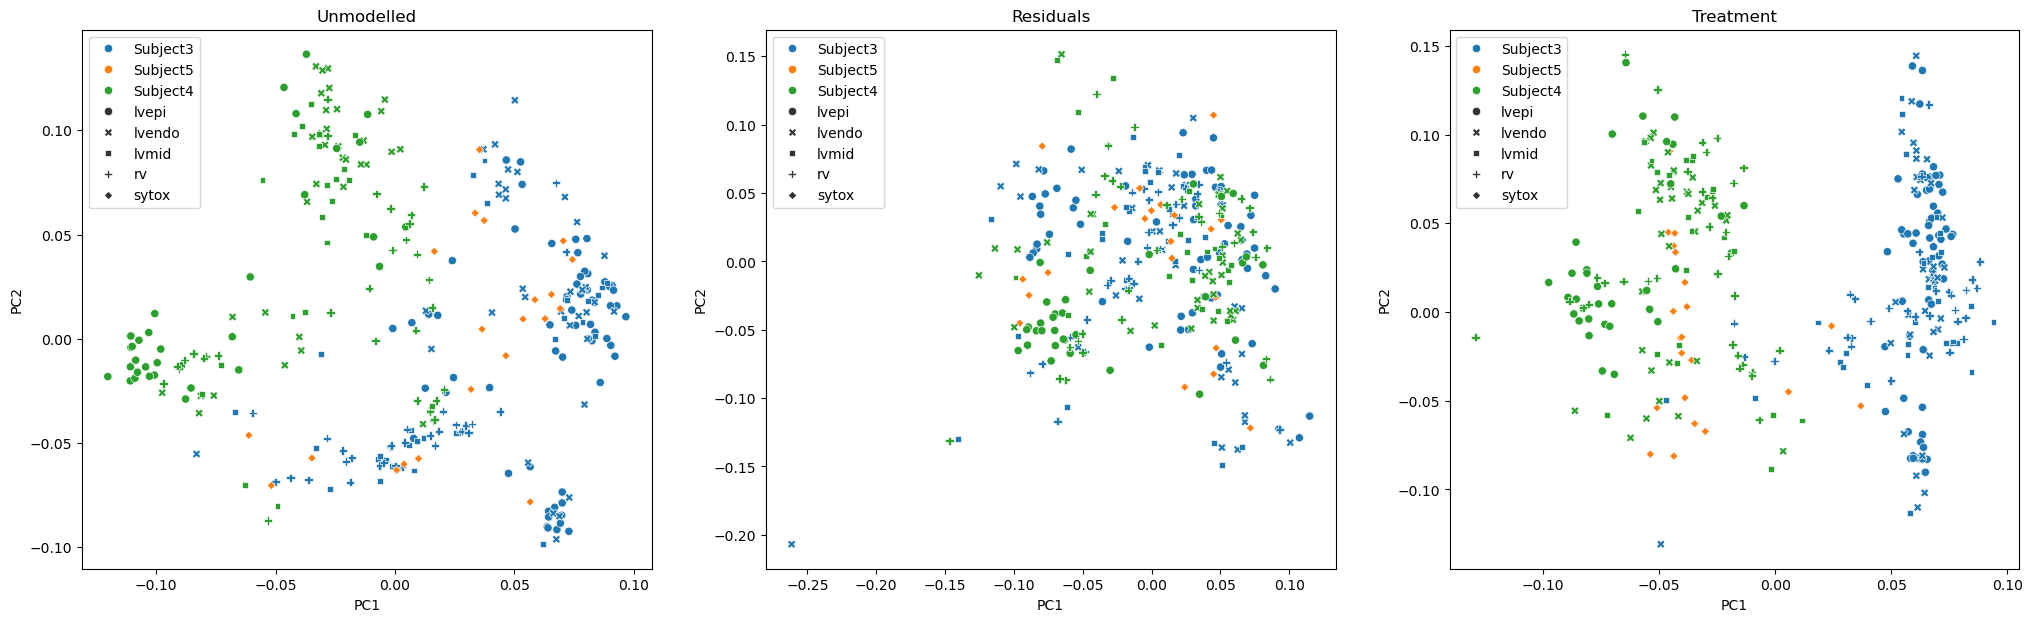

In [129]:
from scplainer.analysis.component import scpComponentAnalysis

caRes = scpComponentAnalysis(
    effect_matrices=em.matrices_collapsed,
    effects=["subject"]
)
plot.scpComponentPlot(
    caRes=caRes,
    coldata=anndata_object.obs,
    color_label='subject',
    style_label='cell_type'
)

# Disclaimer

All analysis below do not make any sense for the following reasons:
- The PCA was performed on the subject level, which was modelled as a technical variable. It should have been done on the cell_type level 
- This dataset is not well suited for trajectory analysis as the dataset just contains different cell types. The iCMs dataset is more suitable.


THe analysis performed here were done just to test whether the code works fine without any bugs

In [131]:
import pickle

with open('subject_pca.pkl', 'wb') as f:
    pickle.dump(caRes, f)

In [136]:
caRes['effect'].keys()

dict_keys(['eig', 'scores', 'loadings', 'fitted', 'ncomp', 'R2', 'iter', 'center', 'scale'])

Extract PCA

In [140]:
pc_by_sample = caRes['effect']['loadings']

In [171]:
anndata_object

AnnData object with n_obs × n_vars = 299 × 12731
    obs: 'cell_type', 'well', 'subject', 'acquisition_data', 'position', 'NumberPeptides', 'MedianIntensity', 'MedianCV'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes'

In [176]:
anndata_for_TI = anndata_object.copy()

In [181]:
caRes['effect']['scores']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
AAAEELLAR2,-0.003569,-0.004062,0.000027,0.008603,0.001399,-0.004096,-0.006758,-0.001641,-0.005247,-0.004167,0.007205,-0.004580,0.008916,-0.000926,-0.002807,-0.000989,-0.000933,0.000693,-0.008150,-0.007257
AAAEELPVGASAGPQPR2,-0.007368,0.000649,-0.001545,0.001259,-0.015663,-0.001781,0.003524,-0.003952,0.005732,0.002687,0.001425,-0.001715,-0.003993,0.004632,-0.004249,0.010764,-0.002060,0.003811,-0.004466,-0.000739
AAAEVNQDYGLDPK2,-0.001531,0.008799,-0.018593,0.009059,-0.007208,-0.000026,-0.005055,-0.007815,0.012345,-0.014573,0.017897,-0.003553,-0.002303,-0.009014,-0.000378,0.014918,0.012441,0.000183,0.001966,-0.008065
AAAFEEQENETVVVK2,-0.013184,-0.000186,0.003573,0.000415,-0.018100,-0.003574,0.001687,-0.002715,-0.000769,0.012079,0.002453,-0.000601,-0.001649,-0.000779,-0.003714,0.004954,-0.002143,-0.001069,0.004602,-0.004807
AAALEQFK2,-0.002735,0.006340,-0.002630,0.003854,-0.006936,0.009974,-0.011980,0.005658,-0.004739,0.008042,0.015364,0.010243,0.010999,-0.001918,0.006012,-0.007025,-0.000890,0.000303,0.012005,-0.004498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYTLNGSK2,-0.002504,-0.000466,0.013967,-0.004353,-0.004033,0.012574,-0.011112,0.002928,-0.016153,-0.008076,0.007236,0.019755,-0.001009,0.007011,0.002314,-0.006025,0.021851,0.005995,-0.005314,0.007981
YYTPTISR2,-0.006396,-0.000110,0.003972,-0.003634,-0.010701,-0.002134,-0.000904,0.000421,-0.002609,0.002548,0.006633,0.003800,-0.007348,-0.003276,0.000917,0.000902,0.000367,-0.007562,-0.005475,0.002320
YYTVFDR2,0.000048,-0.007562,0.005591,0.005204,-0.001973,0.001054,0.014443,-0.002533,0.005256,-0.002879,0.003110,0.009049,0.006163,-0.004130,-0.011119,0.004333,0.006055,-0.008141,-0.007337,-0.015185
YYVTIIDAPGHR2,-0.005045,-0.011061,-0.004127,-0.001280,0.001339,0.000681,-0.012686,-0.021437,-0.006435,0.005425,0.009151,0.029514,0.010749,-0.003941,0.010661,0.039877,0.003716,0.018750,0.002978,0.005572


Filter for pca decomposable features

In [ ]:
anndata_object = AnnData(
    X=data_df,
    obs=annot_df,
    var=var
)

In [188]:
data_df.shape

(299, 12731)

In [189]:
data_df.head()

Precursor.Id,AAAEDVNVTFEDQQK2,AAAEELLAR2,AAAEELPVGASAGPQPR2,AAAEVNQDYGLDPK2,AAAFEEQENETVVVK2,AAALEQFK2,AAALLLQNDNNADVESK2,AAAVLPVLDLAQR2,AAAVPVEFQEHHLSEVQNMASEEK3,AAAVPVEFQEHHLSEVQNMASEEK4,...,YYHTLIK2,YYITIIDAPGHR2,YYITIIDAPGHR3,YYSFFDLNPK2,YYTLEEIQK2,YYTLNGSK2,YYTPTISR2,YYTVFDR2,YYVTIIDAPGHR2,YYVTIIDAPGHR3
File.Name,,,,,,,,,,,,,,,,,,,,,
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A19_BA20_1_7451.d,3045.72,NaN,NaN,9070.84,NaN,NaN,NaN,8431.7,NaN,NaN,...,NaN,20244.30,45473.2,NaN,NaN,NaN,4304.07,8807.75,1388.99,3320.82
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A20_BA21_1_7452.d,NaN,1810.75,NaN,20697.30,NaN,14985.2,NaN,25132.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2276.87,NaN,4438.92,NaN,3970.36
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A21_BA22_1_7453.d,NaN,5533.69,NaN,342106.00,NaN,157505.0,NaN,304373.0,15629.3,22537.0,...,21069.6,3819.35,13939.5,NaN,NaN,20072.80,NaN,103826.00,NaN,6974.10
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A22_BA23_1_7454.d,NaN,NaN,NaN,309252.00,NaN,184474.0,NaN,273999.0,NaN,18108.5,...,NaN,5447.36,11930.6,NaN,NaN,50893.30,NaN,45587.20,NaN,NaN
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A23_BA24_1_7455.d,NaN,NaN,NaN,42956.20,NaN,NaN,NaN,10549.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11475.00,1558.57,NaN


In [199]:
data_df_reduced = data_df.loc[
    data_df.index,
    caRes['effect']['scores'].index
]

In [207]:
varm = caRes['effect']['scores'].to_numpy()
obsm = caRes['effect']['loadings'].to_numpy()

anndata_for_TI = AnnData(
    X=data_df_reduced,
    obs=annot_df,
    var=var.loc[caRes['effect']['scores'].index, :],
    obsm={'X_pca': obsm},
    varm={'PCs': varm}
)

In [208]:
anndata_for_TI

AnnData object with n_obs × n_vars = 299 × 11732
    obs: 'cell_type', 'well', 'subject', 'acquisition_data', 'position'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes'
    obsm: 'X_pca'
    varm: 'PCs'

Make the diffusion map with Palentir

In [209]:
import palantir

In [210]:
dm_res = palantir.utils.run_diffusion_maps(
    anndata_for_TI, 
    n_components=5
)

/home/samva/anaconda3/envs/scplainer_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samva/anaconda3/envs/scplainer_env/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [212]:
ms_data = palantir.utils.determine_multiscale_space(anndata_for_TI)

In [214]:
sc.pp.neighbors(anndata_for_TI)
sc.tl.umap(anndata_for_TI)

In [224]:
anndata_for_TI.obs

,cell_type,well,subject,acquisition_data,position
File.Name,,,,,
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A19_BA20_1_7451.d,lvepi,A19,Subject3,221019,BA20
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A20_BA21_1_7452.d,lvepi,A20,Subject3,221019,BA21
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A21_BA22_1_7453.d,lvepi,A21,Subject3,221019,BA22
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A22_BA23_1_7454.d,lvepi,A22,Subject3,221019,BA23
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A23_BA24_1_7455.d,lvepi,A23,Subject3,221019,BA24
...,...,...,...,...,...
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_F6_BF7_1_7832.d,rv,F6,Subject4,221024,BF7
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G5_BG6_1_7840.d,rv,G5,Subject4,221024,BG6
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G6_BG7_1_7841.d,rv,G6,Subject4,221024,BG7


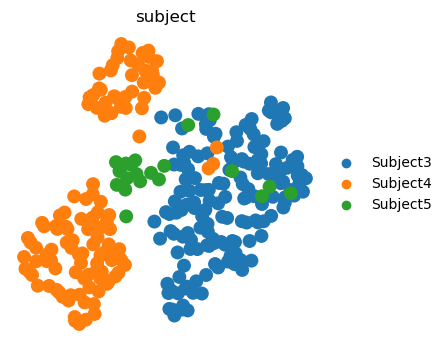

In [235]:
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(
    anndata_for_TI,
    basis="umap",
    color='subject',
    frameon=False,
)

In [219]:
np.random.choice(
    anndata_for_TI.obs.index.tolist()
)

'X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_RV_D4_BD7_1_7515.d'

In [233]:
random_cell = np.random.choice(
    anndata_for_TI.obs.index.tolist()
)

pr_res = palantir.core.run_palantir(
    anndata_for_TI, random_cell, num_waypoints=500
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0003673354784647624 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.0037629087766011555 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


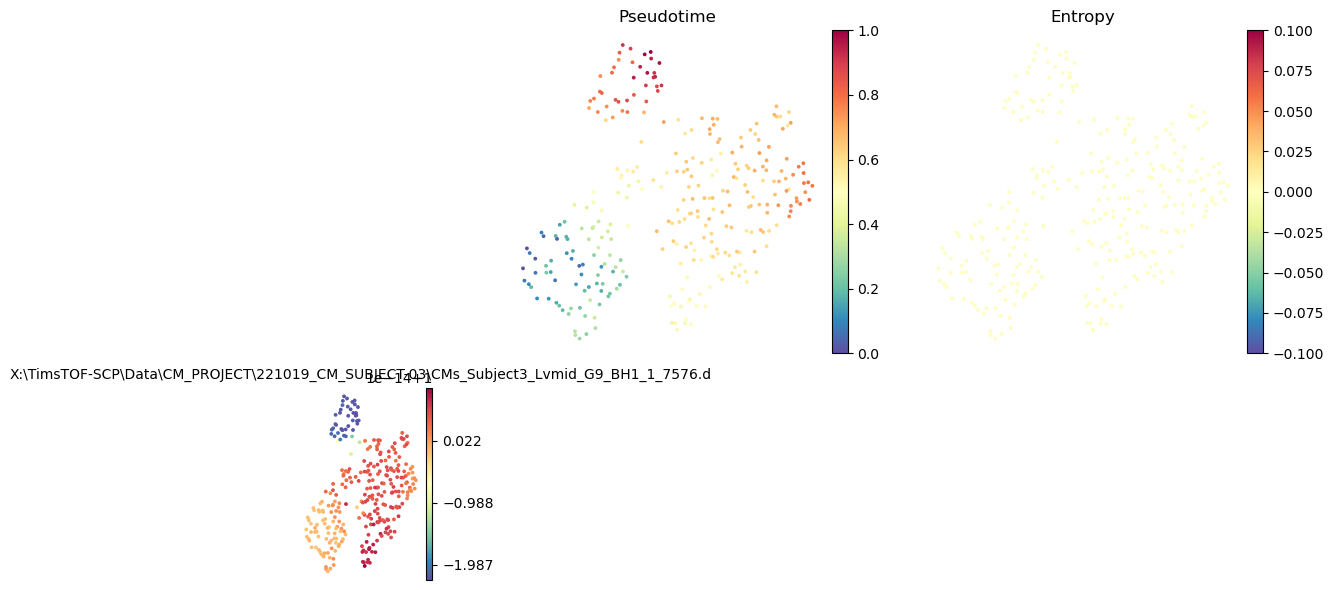

In [234]:

palantir.plot.plot_palantir_results(anndata_for_TI, s=3)
plt.show()

In [238]:
pr_res.branch_probs

,X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_Lvmid_G9_BH1_1_7576.d
File.Name,
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A19_BA20_1_7451.d,1.0
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A20_BA21_1_7452.d,1.0
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A21_BA22_1_7453.d,1.0
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A22_BA23_1_7454.d,1.0
X:\TimsTOF-SCP\Data\CM_PROJECT\221019_CM_SUBJECT-03\CMs_Subject3_LVepi_A23_BA24_1_7455.d,1.0
...,...
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_F6_BF7_1_7832.d,1.0
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G5_BG6_1_7840.d,1.0
X:\TimsTOF-SCP\Data\CM_PROJECT\221024_Subject-04\CMs_Subject4_D_RV_G6_BG7_1_7841.d,1.0


In [241]:
anndata_for_TI.obsm

AxisArrays with keys: X_pca, DM_EigenVectors, DM_EigenVectors_multiscaled, X_umap, palantir_fate_probabilities

: 

In [1]:
anndata_for_TI.obsm['palantir_fate_probabilities']

NameError: name 'anndata_for_TI' is not defined

In [240]:
branch = 'X:\\TimsTOF-SCP\\Data\\CM_PROJECT\\221019_CM_SUBJECT-03\\CMs_Subject3_Lvmid_G9_BH1_1_7576.d'
palantir.plot.plot_trajectory(anndata_for_TI, branch)


KeyError: 'branch_masks not found in ad.obsm'